## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.inspection import plot_partial_dependence

sns.set(style="ticks", color_codes=True)

## Read Data

In [23]:
data = pd.read_csv("terrarium1.csv",sep=",")

#### Dimensions of Data

In [24]:
data.shape

(61596, 17)

#### Peek at the Data

In [25]:
data.head()

,identifier,creatureType,Time,CanReproduce,CanGrow,CanAttack,Energy,MaxEnergy,Size,Age,Activity,herbivores,carnivores,plants,herbivores_e,carnivores_e,plants_e
0,0,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
1,1,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
2,2,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
3,3,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2
4,4,0,0,0,0,0,0.9999,5,1.0,0.011,1,5,2,20,5,2,20.2


#### Data types of Attributes

In [26]:
data.dtypes

identifier        int64
creatureType      int64
Time              int64
CanReproduce      int64
CanGrow           int64
CanAttack         int64
Energy          float64
MaxEnergy         int64
Size            float64
Age             float64
Activity          int64
herbivores        int64
carnivores        int64
plants            int64
herbivores_e      int64
carnivores_e      int64
plants_e        float64
dtype: object

all attributes have correct Data type. Now we can start working on Data.

### Some Pre Processing
If we have any duplicate records then we will remove them and keep first.

In [27]:
data.duplicated().sum()

0

In [28]:
data.drop_duplicates(keep='first', inplace=True)

#### Check Null Values

In [29]:
data.isnull().sum()

identifier      0
creatureType    0
Time            0
CanReproduce    0
CanGrow         0
CanAttack       0
Energy          0
MaxEnergy       0
Size            0
Age             0
Activity        0
herbivores      0
carnivores      0
plants          0
herbivores_e    0
carnivores_e    0
plants_e        0
dtype: int64

### Train Test Split

In [38]:
new_data = data[data['creatureType']== 0]

In [39]:
X_train, X_test, y_train, y_test = train_test_split(new_data.drop(['Activity',"carnivores","carnivores_e",'MaxEnergy',"creatureType","identifier","Time"],axis=1),new_data['Activity'],train_size=0.30,random_state=10,stratify=new_data['Activity'])

To use the RandomizedSearchCV class, I  specify the parameters I want to search over using a dictionary. RandomizedSearchCV will then perform all the necessary model fits. The keys of the dictionary are the names of parameters I wish to adjust.

In [40]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 100, num = 20)]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


Now I will create model instance and use RandomizedSearchCV to perform all the necessary model fits.

In [51]:
rf_instance = RandomForestClassifier( oob_score=True)
rf_random = RandomizedSearchCV(estimator = rf_instance, param_distributions = random_grid, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

Let's check best parameters we find

In [52]:
rf_random.best_params_

{'n_estimators': 684,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [53]:
rf_random.score(X_test,y_test)

0.9123108977262433

# Why we need Model interpretation ?
Train a model that predicts accurately is certainly important, but in most cases one needs both accuracy and interpretability. So by identifying which features are important we can interpretable our model. 
When we know which features are important then we can improve the model by focusing only on the important features and after removing insignificant features we  can get similar or better performance in much shorter training time.

In [54]:
best_rf_model = rf_random.best_estimator_

## Activity  = 0
A partial dependence (PD) plot depicts the functional relationship between a small number of input variables and predictions. They show how the predictions partially depend on values of the input variables of interest.

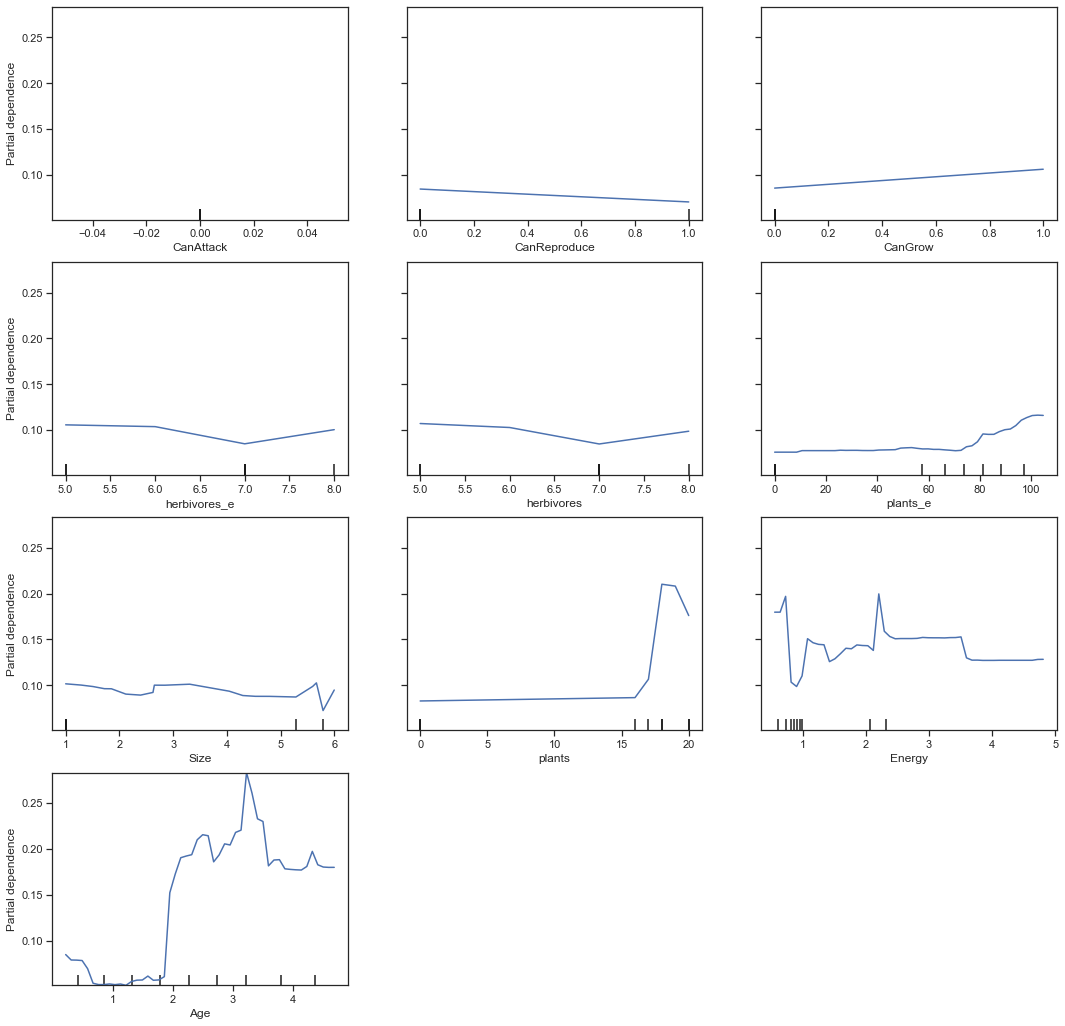

In [57]:
fig, ax = plt.subplots(figsize=(18, 18))
fig = plot_partial_dependence(best_rf_model, X_train, features = np.argsort(best_rf_model.feature_importances_)[-13:],target=0,feature_names=X_train.columns,grid_resolution=50,ax=ax)

For Activity=0 Age is the most important attribute and from the age curve we can see that as age value increases the prediction values goes down. After age = 2 partial dependence tends to increase until 3.4 and then its ability to predict decreases.
 

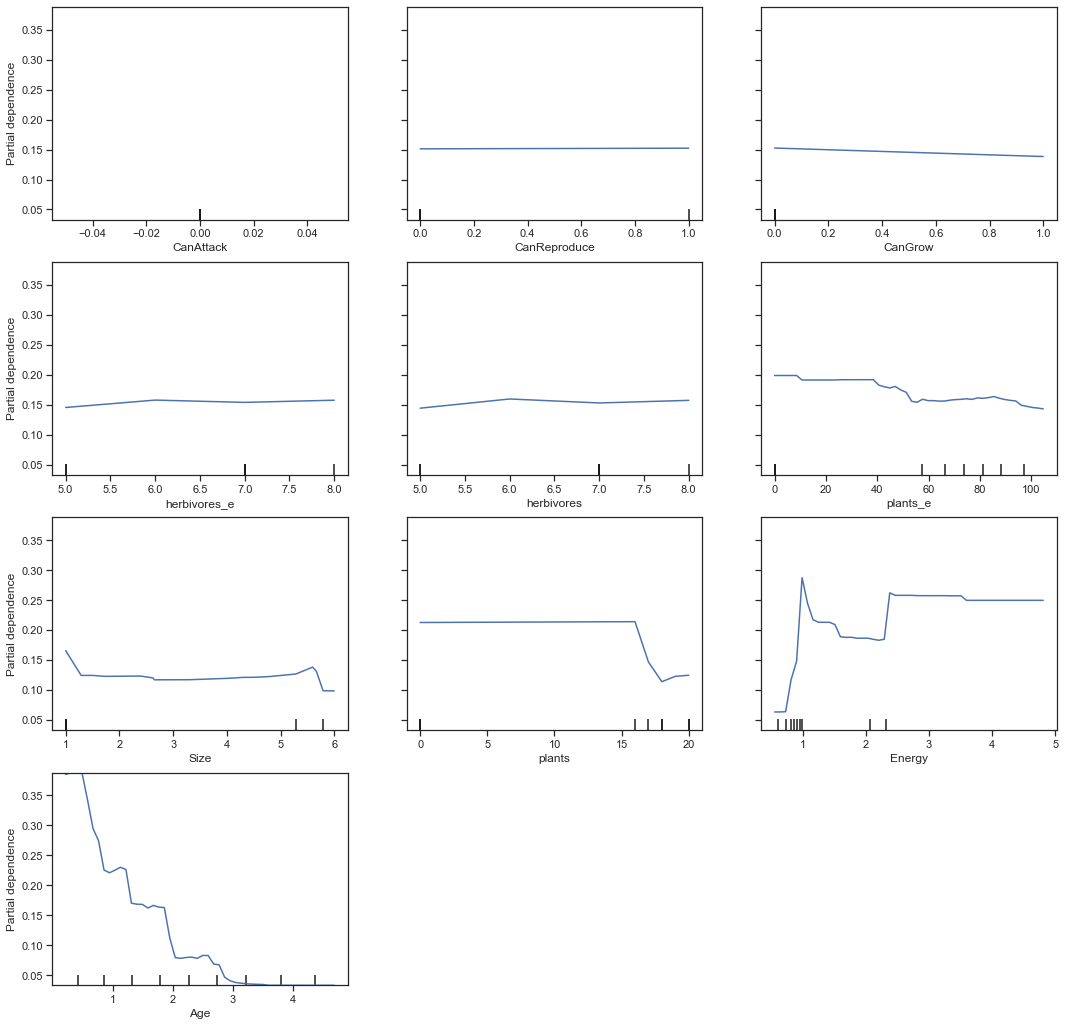

In [58]:
fig, ax = plt.subplots(figsize=(18, 18))
fig = plot_partial_dependence(best_rf_model, X_train, features = np.argsort(best_rf_model.feature_importances_)[-13:],target=1,feature_names=X_train.columns,grid_resolution=50,ax=ax)

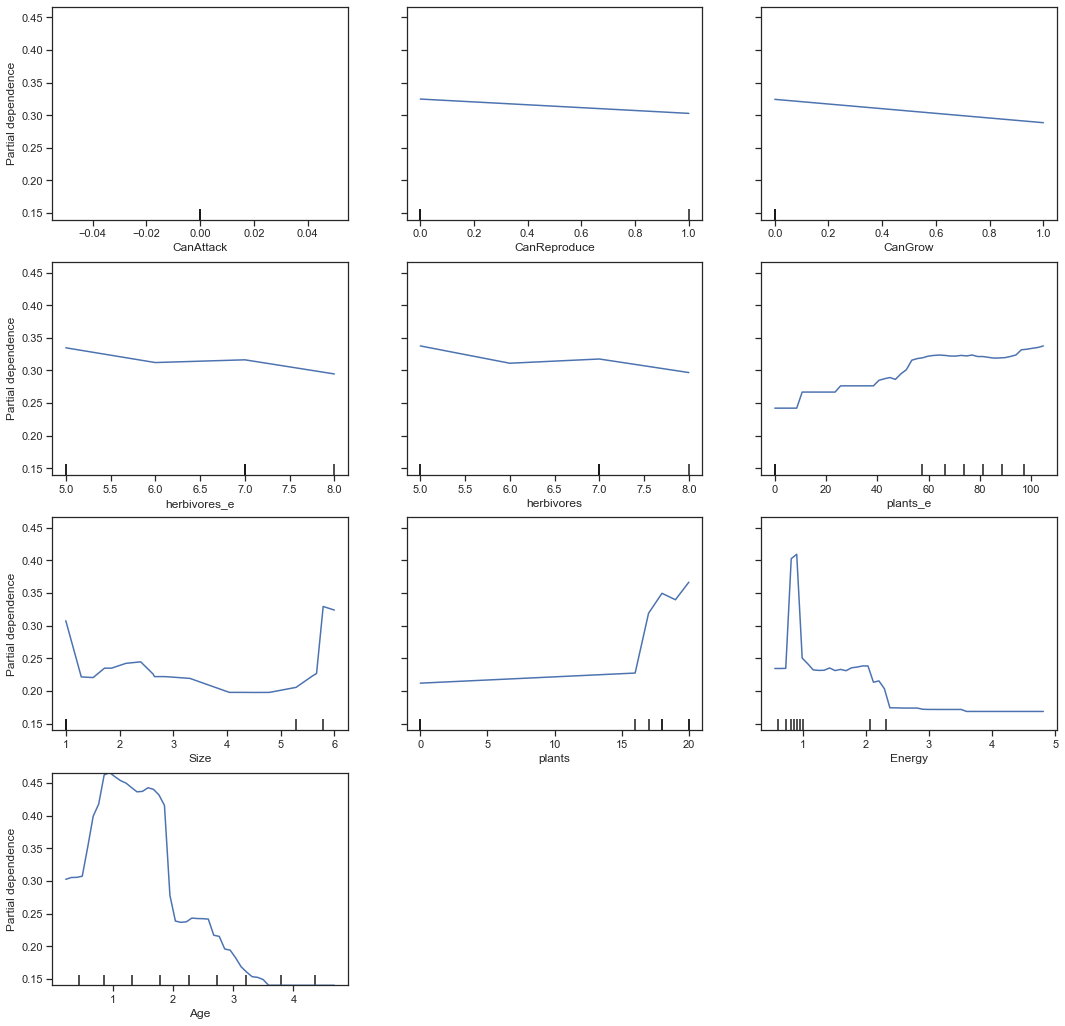

In [59]:
fig, ax = plt.subplots(figsize=(18, 18))
fig = plot_partial_dependence(best_rf_model, X_train, features = np.argsort(best_rf_model.feature_importances_)[-13:],target=2,feature_names=X_train.columns,grid_resolution=50,ax=ax)

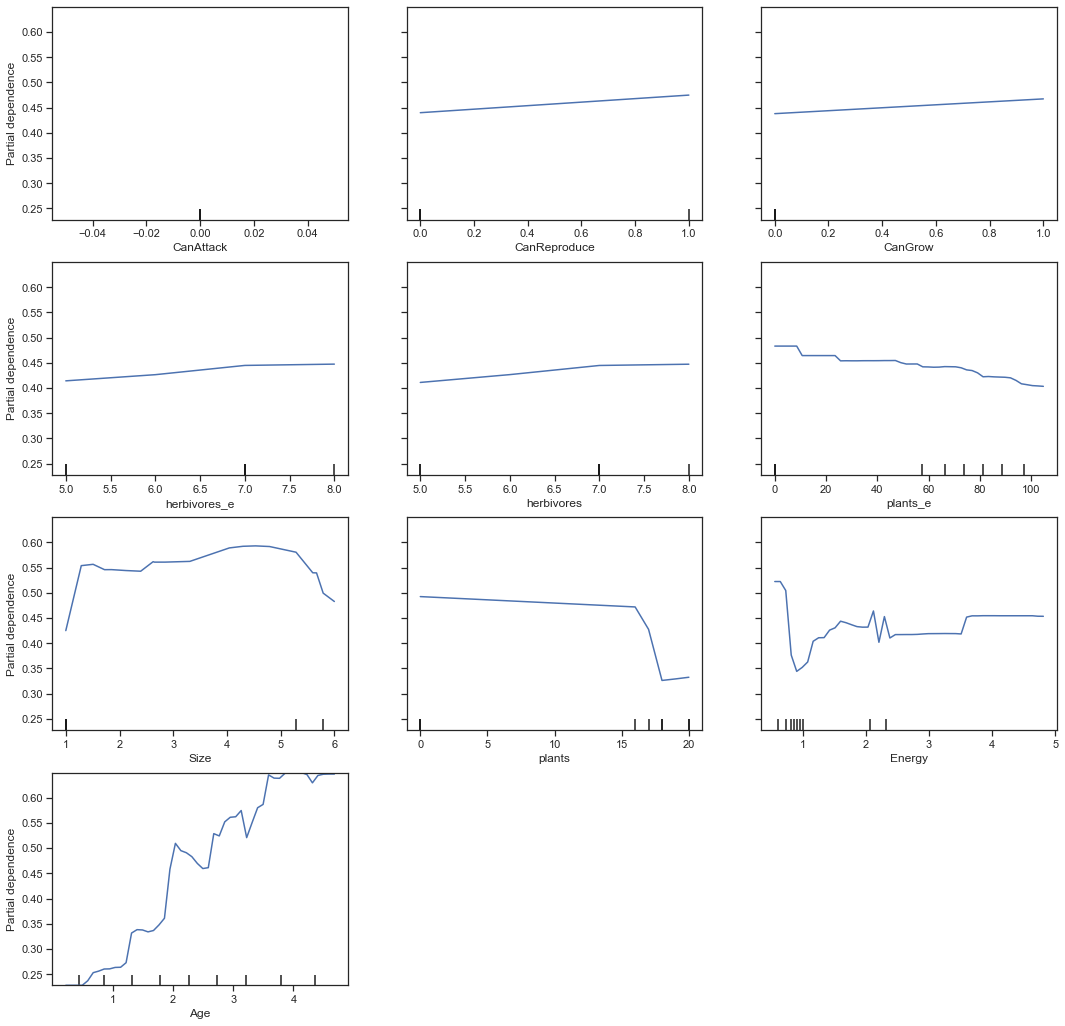

In [61]:
fig, ax = plt.subplots(figsize=(18, 18))
fig = plot_partial_dependence(best_rf_model, X_train, features = np.argsort(best_rf_model.feature_importances_)[-13:],target=3,feature_names=X_train.columns,grid_resolution=50,ax=ax)